In [2]:
using Primes
using PyPlot
using BenchmarkTools
BenchmarkTools.DEFAULT_PARAMETERS.samples = 50;

In [48]:
length(primes(7919))

1000

In [49]:
function initialize(n, pₙ)
    d = primes(pₙ)
    Aₙ = spdiagm(d, 0)
    e = ones(n, 1)

    for k in 2.^( 0:floor(Int,log2(n)))
        eₖ = e[1:(n-k)]
        Aₙ = Aₙ + spdiagm( [eₖ,eₖ], [-k k])       
    end
    
    Aₙ
end

n = 1000#100 #10 # 2000 #20000
pₙ = 7919#543#29# 17389 #224737

Aₙ = initialize(n, pₙ)
b = zeros(n); b[1] = 1;

In [31]:
# Bounded Insertion sort
# This is actually a copy paste of https://github.com/JuliaLang/julia/blob/v0.5.1/base/sort.jl#L218
# but I couldn't find how to actually call this function 
function bounded_insertion_sort!(v::AbstractVector, lo::Int, hi::Int, by=identity)
    @inbounds for i = lo+1:hi
        j = i
        x = v[i]
        while j > lo
            if by(x) < by(v[j-1])
                v[j] = v[j-1]
                j -= 1
                continue
            end
            break
        end
        v[j] = x
    end
    return v
end

bounded_insertion_sort! (generic function with 2 methods)

In [32]:
function sort_inverse(p)
    out = [ i for i in 1:length(p) ]
    @inbounds for i = 1:length(p)
        out[p[i]] = i
    end
    out
end

# Reverse Cuthill McKee
function rcm(A::SparseMatrixCSC)
    n = size(A, 1)
    x₀ = 0
    
    # bookkeeping on the nodes to know which ones have to be enqueued
    visited = falses(n)
    touched = falses(n)
    
    # pre compute the degree of each node in the graph
    degrees = [0 for i in 1:n]
    @inbounds for i=1:n
        # see internal representation of CSR
        degrees[i] = Aₙ.colptr[i+1] - Aₙ.colptr[i]
    end
    
    # pre-compute the degree ordering
    sorted = sortperm(degrees)
    sorted_inv = sort_inverse(sorted)
    
    # the queue will contain the resulting permutation as well as the
    # next nodes to process withing queue[queue_start : queue_end]
    queue = [0 for i in 1:n]
    queue_start = 1
    queue_end = 1

    while queue_start < n
        # here the queue is empty, we look for the leastconnected node that was not visited
        # so far to repopulate the queue
        @inbounds for i = 1:n
            if !visited[i]
                x₀ = sorted[sorted_inv[i]] 
                break
            end
        end
        
        # enqueue x₀
        touched[x₀] = true
        queue[queue_end] = x₀
        queue_end += 1
        
        # process the queue
        while queue_start < queue_end
            # pop out one element
            x = queue[queue_start]
            visited[x] = true
            queue_start += 1
            
            # add the nodes adjacent to the current node to the queue, ignoring node
            # that were already queued
            adj_len = 0

            # iterate over the non-zero elements of the x column
            @inbounds for i = Aₙ.rowval[Aₙ.colptr[x]:(Aₙ.colptr[x+1]-1)]
                if !touched[i]
                    queue[queue_end + adj_len] = i
                    touched[i] = true
                    adj_len += 1
                end
            end
            
            if adj_len == 0
                continue
            end
            
            # sort the nodes we've just added to the queue and finish the growing process by moving queue_end
            bounded_insertion_sort!(queue, queue_end, queue_end + adj_len - 1, adj -> sorted_inv[adj])   
            queue_end += adj_len
        end
    end
    
    reverse(queue)
end

rcm (generic function with 1 method)

In [33]:
function solve_chol_RCM(Aₙ,b) 
    p = rcm(Aₙ)
    F = cholfact(Aₙ, perm = p)
    x = F\b
    return x[1]
end

solve_chol_RCM (generic function with 1 method)

In [50]:
@time p = rcm(Aₙ)
@time F = cholfact(Aₙ, perm = p)
@time x = F\b;

x[1]

  0.003661 seconds (38.77 k allocations: 1.144 MB)
  0.062760 seconds (66 allocations: 3.949 MB)
  0.000870 seconds (16 allocations: 34.945 KB)


0.724945321896466

In [23]:
using Base.SparseArrays.CHOLMOD
@edit solve(CHOLMOD_A, F, convert(Dense{Float64}, b))

LoadError: UndefVarError: solve not defined

Permuted Matrix AₙNon zero entries: 

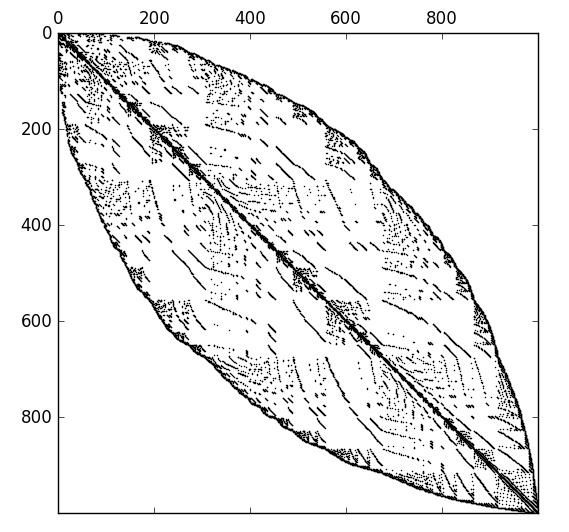

1.8954%

In [52]:
print("Permuted Matrix Aₙ")
spy(Aₙ[p,p], markersize = 0.5) 

print("Non zero entries: ", nnz(Aₙ)/length(full(Aₙ))*100, "%") 

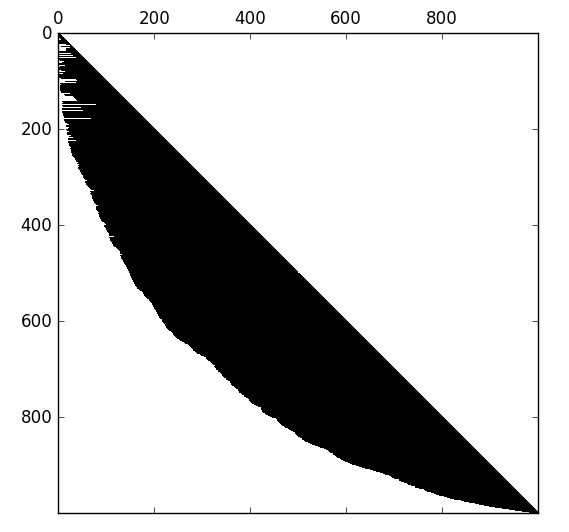

L-Matrix of the Cholesky FactorisationDensity of the lower half: 56.115 %

In [53]:
L = sparse(F[:L])
spy(L);

print("L-Matrix of the Cholesky Factorisation")
print("Density of the lower half: ", 2*nnz(L)/length(full(L))*100, " %");


### Why is it faster

We must admit that the reason why this factorization leads to better performances stayed a mystery for a long time. How can solving a linear equation perform better on a matrix that is more filled?

The reason for this is a method called supernodal factorization. Supernodal factorization will not result in a different Cholesky factorization of $A$, but it will create a data structure on top of the L factor representing a solving plan for solving the equation $Lx_1 = y$ and $L'x = x_1$.

The plan constructed by the algorithm is based on a common idea in the field of sparse matrix solvers. The idea is to look at sparse matrices as adjacency graphs. This means that a non-zero entry at position $(i, j)$ of matrix $L$ denotes an edge going from node $i$ to node $j$ in the underlying graph.

TODO: create a nice toy matrix A and display its graph (in julia)
TODO: talk about how each node has to be evaluated only once => eliminate duplicates from the tree

This concept gets much more interesting and powerful when using it in the context of triangular matrices. Indeed, in the context of triangular matrices, the underlying graph is unidirectional (TODO: there is a better word), which means that for each edge $(i, j)$ from node $i$ to node $j$, the constraint $i \ge j$ must be filled. This means that an edge can only go from a node to a lower-index node (or to itself). Because our $L$ matrix is invertible, we will always have a non-zero factor on the diagonal, and thus every node has an edge to itself, thus, to make the argumentation easier, we will at first ignore this edge. The second consequence on the edge property (TODO: give it a name?) is that our graph cycle free. This means that we can look at it as a proper evaluation dependency graph, where an edge $(i, j)$ means that the evaluation of node $i$ is dependent on the value of the node $j$.

TODO: this time, we choose a triangular matrix, and plot it too

The attentive reader will probably already see how this dependency graph can already used to construct a plan for solving our equation, but this graph is not going to be enough to get performance improvements when solving our linear system.

The second concept we have to mention in order to understand this performance advantage is the concept of supernodes. Informally, a supernode is a set of node which share the set of dependent nodes. More formally we have: 

Let $S \subset K$ be a supernode, then following properties must hold.
+ $\forall i \in S: \forall j \in S: j \leq i \implies (i, j) \in E$ (self-reference)
+ $\forall i \in K: (\exists j \in S: (i, j) \in E) \implies (\forall j \in S: (i, j) \in E)$ (shared dependent nodes) 

This concept allow us to see the evaluation of a supernode as a unit in our dependency graph. This means that the evaluation of our supernode will be enough step forward in the evaluation of the (shared) dependent nodes.

TODO: redraw the graph with supernodes

This bring us to the reason why supernodal matrix factorization brings better performances. Because nodes in a supernode will always be used together, we can save them together in memory, leading to a better usage of the memory caches. Second, we can also adapt our memory layout to perform all of our solving operations as level2-3 BLAS operations. We do this by splitting the supernode in two dense matrices:
+ the $L_1$ matrix, storing the coefficients of the self reference nodes
+ the $L_2$ matrix, storing the coefficients of the shared references of other nodes on the supernode.

This leads to the following algorithm to solve Lx = b (https://github.com/PetterS/SuiteSparse/blob/27e5a8516464a6ac40bd3fa0e5b46e51b11f4765/CHOLMOD/Supernodal/t_cholmod_super_solve.c#L17)

```
permute b to use the supernodes depency tree layout
for each supernode in supernodes:
    e = L1 \ b[supernode.start : supernode.end]
    x = x[supernode.start : supernode.end] - L2 * e
permute x back
```

Thus, even if the RCM permutation will result in more fill-in, it will reduce the spreading of the non zero elements, bringing them all close to the diagonal. This results in a small number of supernodes, leading to better perf.

(https://github.com/PetterS/SuiteSparse/blob/27e5a8516464a6ac40bd3fa0e5b46e51b11f4765/CHOLMOD/Supernodal/t_cholmod_super_solve.c#L17 and https://www.researchgate.net/publication/220492578_Algorithm_887_CHOLMOD_Supernodal_Sparse_Cholesky_Factorization_and_UpdateDowndate)
we see in the next block that only 29 supernodes are used against 231 supernodes for the AMD version.

TODO: classical literature uses the term elimination tree: we should di this as well

https://github.com/PetterS/SuiteSparse/blob/master/CHOLMOD/Cholesky/cholmod_solve.c#L948
https://github.com/PetterS/SuiteSparse/blob/27e5a8516464a6ac40bd3fa0e5b46e51b11f4765/CHOLMOD/Supernodal/cholmod_super_solve.c#L45
https://github.com/PetterS/SuiteSparse/blob/27e5a8516464a6ac40bd3fa0e5b46e51b11f4765/CHOLMOD/Supernodal/t_cholmod_super_solve.c#L17

In [61]:
c = unsafe_load(F.p)

println("Current factorixation contains ", c.nsuper, " supernodes:")
println("L1\tL2\tx1")
for i = 1:c.nsuper
    k1 = unsafe_load(c.super, i)
    k2 = unsafe_load(c.super, i+1)
    psi = unsafe_load(c.pi, i)
    psend = unsafe_load(c.pi, i+1)
    nsrow = psend - psi
    nscol = k2 - k1
    nsrow2 = nsrow - nscol
    
    println(nscol, "x", nscol, "\t", nsrow2, "x", nscol, "\t", nscol, "x", nsrow)
end


Current factorixation contains 21 supernodes:
L1	L2	x1
15x15	121x15	15x136
16x16	186x16	16x202
16x16	236x16	16x252
24x24	270x24	24x294
30x30	310x30	30x340
41x41	345x41	41x386
48x48	366x48	48x414
48x48	387x48	48x435
58x58	374x58	58x432
48x48	372x48	48x420
47x47	368x47	47x415
54x54	356x54	54x410
52x52	340x52	52x392
71x71	307x71	71x378
90x90	254x90	90x344
58x58	219x58	58x277
59x59	182x59	59x241
66x66	134x66	66x200
68x68	79x68	68x147
49x49	37x49	49x86
42x42	0x42	42x42


https://www.linkedin.com/in/adrian-mascarenhas-7a701019/
wrote 
http://etd.fcla.edu/UF/UFE1000140/mascarenhas_a.pdf
todo: send him a mail to thank him for writing a clear explaination of supernodal factorization